In [1]:
using Revise
# import Pkg; Pkg.status()

In [2]:
import PyCall

import OccGrid as O
import PointCloud as PC

# If undefined: (@v1.6) pkg> dev PointCloud
import PointCloud: CameraIntrinsics

import Control: BeliefState, execute_command!
import PoseComposition: Pose, IDENTITY_POSE, IDENTITY_ORN
using StaticArrays

global MCS = PyCall.pyimport("machine_common_sense")
global np = PyCall.pyimport("numpy")

PyObject <module 'numpy' from '/usr/local/lib/python3.8/dist-packages/numpy/__init__.py'>

In [3]:
cora_path = get(ENV, "CORA_PATH", "/cora")
cora_agent_path = joinpath(cora_path, "cora-agent")
scene_path = joinpath(cora_agent_path, "test/data/eval5/ball_behind_sofa.json")
config_path = joinpath(cora_agent_path, "test/data/config_level2.ini")

if "MCS_CONFIG_FILE_PATH" ∈ keys(ENV)
    println("\nWARNING: MCS_CONFIG_FILE_PATH is set and might interfere with your defined information level.")
end

if isfile(config_path)
    controller = MCS.create_controller(config_file_or_dict=config_path)
else
    println("Error: Config file path \"$(config_path)\" does not exist.")
end

if isfile(scene_path)
    scene_config = MCS.load_scene_json_file(scene_path);
else
    println("Error: Scene path \"$(scene_path)\" does not exist.")
end

Found path: /root/.mcs/0.5.2/MCS-AI2-THOR-Unity-App-v0.5.2.x86_64


Dict{Any, Any} with 8 entries:
  "performerStart"  => Dict{Any, Any}("rotation"=>Dict{Any, Any}("x"=>0, "y"=>0…
  "name"            => "soccer_ball_retrieval_example"
  "floorMaterial"   => "AI2-THOR/Materials/Fabrics/CarpetWhite 3"
  "ceilingMaterial" => "AI2-THOR/Materials/Walls/Drywall"
  "objects"         => Dict{Any, Any}[Dict("salientMaterials"=>["fabric"], "mat…
  "wallMaterial"    => "AI2-THOR/Materials/Walls/DrywallBeige"
  "goal"            => Dict{Any, Any}("metadata"=>Dict{Any, Any}("target"=>Dict…
  "version"         => 2

In [4]:
step_metadata = controller.start_scene(scene_config)

PyObject <machine_common_sense.step_metadata.StepMetadata object at 0x7f3a3d288580>

In [5]:
intrinsics = CameraIntrinsics(step_metadata)

Geometry.CameraIntrinsics
  width: Int64 600
  height: Int64 400
  fx: Float64 514.2991467983065
  fy: Float64 514.2991467983065
  cx: Float64 300.0
  cy: Float64 200.0
  near: Float64 9.999999747378752e-5
  far: Float64 9999.0


In [6]:
belief_state = BeliefState(
    intrinsics=intrinsics,
    step_metadata_history=[step_metadata],
    action_history=[],
    pose_history=[IDENTITY_POSE],
    information_level="level2",
    time_to_live=0
);

# obs = [step_metadata] ∪ [execute_command!(controller, belief_state, "RotateRight") for _  in 1:35];
for _  in 1:35
    execute_command!(controller, belief_state, "RotateRight")
end

In [7]:
PC.realign_world!(belief_state)

In [8]:
occupancy_grid_config = O.OccupancyGridConfig(SVector{3, Float64}([0.3, 0.3, 0.3]))
occupancy_grid = O.OccupancyGrid(occupancy_grid_config)

OccGrid.OccupancyGrid(OccGrid.OccupancyGridConfig([0.3, 0.3, 0.3], 1), Dict{SVector{3, Int64}, Int64}(), Dict{SVector{3, Int64}, Int64}(), [0, 0, 0], [0, 0, 0], [0, 0, 0])

In [9]:
objects_only_cloud, world_bbox, perception_updated_until = PC.perception_initializiation(belief_state, occupancy_grid, 1, length(belief_state.pose_history));

## Render Naively
The following will render the `objects_only_cloud` just extracted.

In [10]:
import Images as I
try
    import MeshCatViz as V
catch
    import MeshCatViz as V    
end

V.setup_visualizer()

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8702
└ @ MeshCat /root/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


Could not open browser automatically: Base.IOError("could not spawn `xdg-open http://127.0.0.1:8702`: no such file or directory (ENOENT)", -2)
Please open the following URL in your browser:
http://127.0.0.1:8702


In [11]:
V.viz(objects_only_cloud[1:3, :] ./ 5.0; color=I.colorant"black", channel_name=:gen_cloud)

MeshCat Visualizer with path /meshcat/gen_cloud at http://127.0.0.1:8702

## Compute Mesh
The following will turn the object point cloud into a mesh and render out a depth map based on it.

In [12]:
import GLRenderer as GL
import InverseGraphics as T
import PoseComposition: Pose, IDENTITY_POSE, IDENTITY_ORN, QuatRotation, RotZYX

function get_cloud(poses, ids, camera_pose)
    depth_image = GL.gl_render(renderer, ids, poses, camera_pose)
    cloud = GL.depth_image_to_point_cloud(depth_image, camera)
    if isnothing(cloud)
        cloud = zeros(3,1)
    end
    cloud
end

resolution = 0.1

# import SceneGenerativeModel as SGM
# Note: occupancy_grid_config.grid_resolution is vector of length 3, but function needs single value
# mesh = SGM.cloud_to_mesh(objects_only_cloud[1:3, :], resolution)

# TODO function occupancy_grid_to_mesh(occupancy_grid)
voxel_grid = GL.voxelize(objects_only_cloud[1:3, :], resolution)
mesh = GL.mesh_from_voxelized_cloud(voxel_grid, resolution)

GLRenderer.Mesh
  vertices: Array{Float64}((3, 328560)) [4.65 4.75 … -2.55 -2.45; 0.65 0.65 … -1.45 -1.45; -2.2500000000000004 -2.2500000000000004 … 4.95 4.95]
  indices: Array{Int64}((3, 164280)) [0 1 … 328556 328557; 2 2 … 328558 328558; 1 3 … 328557 328559]
  normals: Array{Float64}((3, 328560)) [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 1.0 1.0; 1.0 1.0 … 0.0 0.0]
  tex_coords: Nothing nothing
  tex_path: Nothing nothing


In [13]:
IDX = 1000
YCB_DIR = joinpath(dirname(pwd()),"data")
world_scaling_factor = 10.0
id_to_cloud, id_to_shift, id_to_box  = T.load_ycbv_models_adjusted(YCB_DIR, world_scaling_factor);

gt_poses, ids, gt_rgb_image, gt_depth_image, cam_pose, original_camera = T.load_ycbv_scene_adjusted(
    YCB_DIR, IDX, world_scaling_factor, id_to_shift
);

In [14]:
?GL.CameraIntrinsics

No documentation found.

# Summary

```
struct GLRenderer.CameraIntrinsics <: Any
```

# Fields

```
width  :: Int64
height :: Int64
fx     :: Float64
fy     :: Float64
cx     :: Float64
cy     :: Float64
near   :: Float64
far    :: Float64
```


In [15]:
function GlCameraIntrinsics(step_metadata::PyCall.PyObject)::GL.CameraIntrinsics
    width, height = step_metadata.camera_aspect_ratio
    aspect_ratio = width / height

    # Camera principal point is the center of the image.
    cx, cy = width / 2.0, height / 2.0

    # Vertical field of view is given.
    fov_y = deg2rad(step_metadata.camera_field_of_view)
    # Convert field of view to distance to scale by aspect ratio and
    # convert back to radians to recover the horizontal field of view.
    fov_x = 2 * atan(aspect_ratio * tan(fov_y / 2.0))

    # Use the following relation to recover the focal length:
    #   FOV = 2 * atan( (0.5 * IMAGE_PLANE_SIZE) / FOCAL_LENGTH )
    fx = cx / tan(fov_x / 2.0)
    fy = cy / tan(fov_y / 2.0)

    # clipping_near, clipping_far = step_metadata.camera_clipping_planes
    clipping_near, clipping_far = 0.1, 25

    GL.CameraIntrinsics(width, height,
        fx, fy, cx, cy,
        clipping_near, clipping_far)
end

# Instead of YCB camera scaled down by factor 4, use MCS camera without scaling
# camera = T.scale_down_camera(original_camera, 4)
camera = GlCameraIntrinsics(step_metadata)
camera.near
renderer = GL.setup_renderer(camera, GL.DepthMode())

gl_version_for_shaders = "410"
true


GLRenderer.Renderer{GLRenderer.DepthMode}(GLFW.Window(Ptr{Nothing} @0x000000001e050120), GLRenderer.CameraIntrinsics
  width: Int64 600
  height: Int64 400
  fx: Float64 514.2991467983065
  fy: Float64 514.2991467983065
  cx: Float64 300.0
  cy: Float64 200.0
  near: Float64 0.1
  far: Float64 25.0
, 0x00000003, Any[], Any[], Any[], Float32[1.7143304 0.0 0.0 0.0; 0.0 2.5714955 0.0 0.0; 0.0 0.0 -1.0080321 -0.2008032; 0.0 0.0 -1.0 0.0])

In [16]:
# camera.near = intrinsics.near
# step_metadata.camera_clipping_planes

In [17]:
V.reset_visualizer()

MeshCat Visualizer with path /meshcat at http://127.0.0.1:8702

In [18]:
GL.load_object!(renderer, mesh)

true

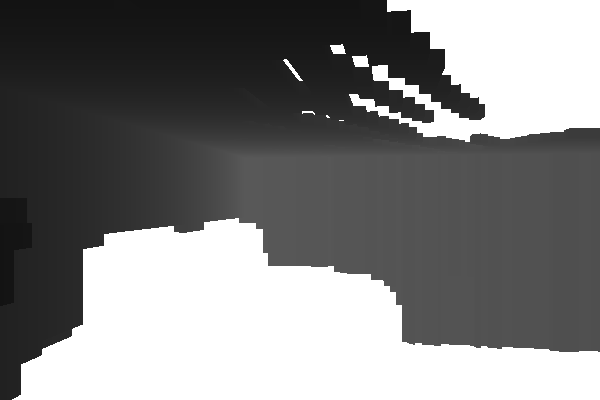

In [19]:
ids = [1]
# pose = Pose([0.7400052114043696, 0.8726610699919363, 8.712766016937628],
#              QuatRotation(0.43682484719575687, 0.7508444627918284,
#                           0.47275777555610393, -0.14804300462534098))
# pose = Pose([0.0, 0.0, 0.0], RotZYX(0, deg2rad(-210.0), 0.0))
pose_mcs = last(belief_state.pose_history)
pose = Pose(pose_mcs.pos, RotZYX(0, deg2rad(-260.0), 0.0))
poses = [pose]
depth_image = GL.gl_render(renderer, ids, poses, IDENTITY_POSE)
GL.view_depth_image(clamp.(depth_image, 0.0, 200.0))

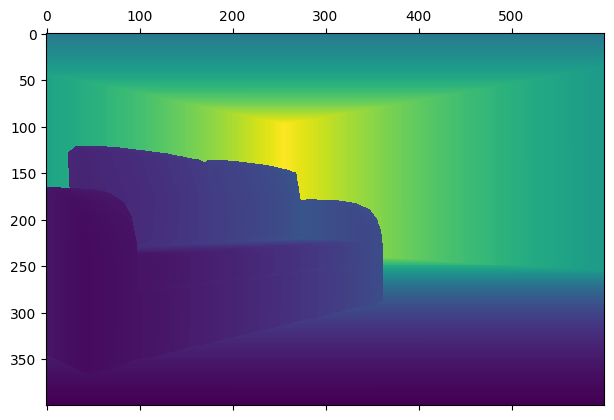

In [21]:
PyCall.py"""
import matplotlib.pyplot as plt

def matshow(mat):
    plt.matshow(mat)
"""

depth_map_gt = last(belief_state.step_metadata_history[24].depth_map_list)
PyCall.py"matshow"(depth_map_gt)
# RGB: last(belief_state.step_metadata_history[24].image_list)

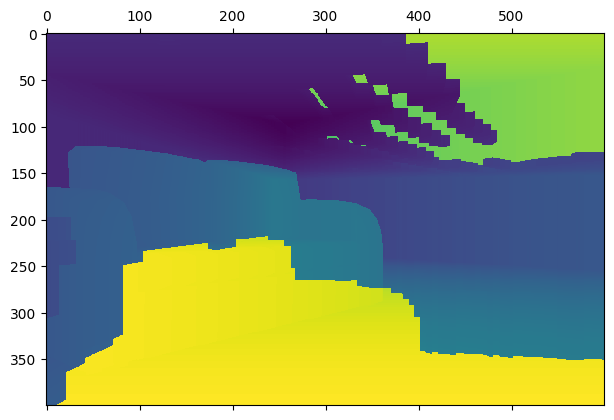

In [22]:
diff = depth_image - depth_map_gt
PyCall.py"matshow"(diff)

In [ ]:
min_a, max_a = minimum(depth_image), maximum(depth_image)
min_b, max_b = minimum(depth_map_gt), maximum(depth_map_gt)
println("$(min_a) to $(max_a) versus $(min_b) to $(max_b)")
max_a / max_b